In [4]:
import sys
sys.path.append('../')
from torchdyn.models import *; from torchdyn.datasets import *

### Generating data

Mass-Spring-Damper system:

In [40]:
class ControlledSystem(nn.Module):
    """Stable Neural Flow"""
    def __init__(self, p, Phi, Psi, m, k, b, qr, c, g):
        super().__init__()
        self.p = p
        self.Phi, self.Psi = Phi, Psi
        self.c = 1. # control yes/no [1./0.]
        
    def _energy_shaping(self, q):
        Phi = self.Phi(q[:,None]).sum()
        grad_Phi = torch.autograd.grad(Phi, q, create_graph=True)[0]
        return -grad_Phi[:,None]
        
    def _damping_injection(self, x):
        m = self.p[0]
        return -self.Psi(x).abs()*x[:,1][:,None]/m 
    
    def _autonomous_energy(self, x):
        k = self.p[1]
        return (m*x[:,1][:,None]**2)/2. + (k*(x[:,0][:,None] - qr)**2)/2.
    
    def _energy(self, x):
        m, k = self.p[:2]
        return (m*x[:,1][:,None]**2)/2. + (k*(x[:,0][:,None] - qr)**2)/2. + self.Phi(x[:,0][:,None])
    
    def forward(self, x):
        m, k, b = self.p[:3]
        with torch.set_grad_enabled(True):
            q, p = x[:,0], x[:,1]
            q = q.requires_grad_(True)
            # compute control action
            self.u = self._energy_shaping(q) + self._damping_injection(x)
            # compute dynamics
            dqdt = p[:,None]/m
            dpdt = -k*(q[:,None] - qr) -b*p[:,None]/m + self.c*self.u#.clamp(-1,1)
        return torch.cat([dqdt, dpdt], 1)

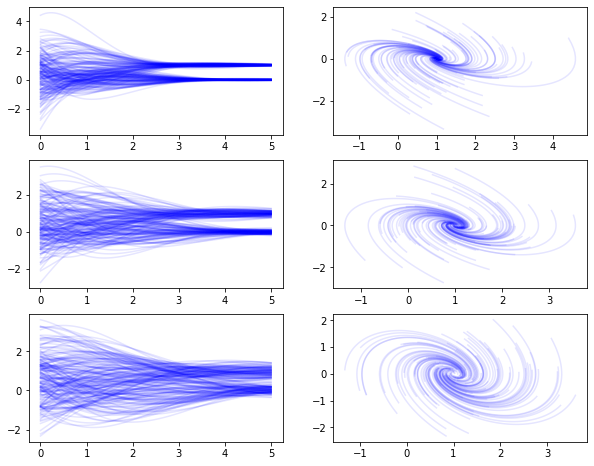

In [181]:
fig = plt.figure(figsize=(10, 8))
for i, m in enumerate([0.6, 1, 1.4]):
    # vector field parametrized by a NN
    Phi = nn.Sequential(
              nn.Linear(1, 64),
              nn.Tanh(), 
              nn.Linear(64, 1))

    Psi = nn.Sequential(
              nn.Linear(2, 64),
              nn.Tanh(), 
              nn.Linear(64, 1))

    f = ControlledSystem([m, 1, 1], Phi, Psi)

    # neural ODE
    model = NeuralDE(f, 
                     order=1,
                     solver='dopri5', 
                     sensitivity='adjoint', 
                     s_span=torch.linspace(0,5,10)).to(device)
    seq = nn.Sequential(model)

    t_span = torch.linspace(0,5,100)
    x0 = torch.tensor([[1, 0]]).to(device)
    x0 = x0 + torch.randn(100, 2).to(device)
    model.defunc.m.c = 0.
    uncontrolled_trajectory = model.trajectory(x0, t_span).detach().cpu()
  
    ax0 = fig.add_subplot(3,2,2*i+1)
    ax1 = fig.add_subplot(3,2,2*i+2)

    for i in range(len(x0)):
        ax0.plot(t_span, uncontrolled_trajectory[:,i,:], color='b', alpha=.1)

    for i in range(len(x0)):
        ax1.plot(uncontrolled_trajectory[:,i,0], uncontrolled_trajectory[:,i,1], color='b', alpha=.1)

## Dataset

In [182]:
data = [] ; from tqdm import tqdm_notebook as tqdm
for i, m in enumerate([0.6, 1, 1.4]):
    for _ in tqdm(range(1)):
        # vector field parametrized by a NN
        Phi = nn.Sequential(
                  nn.Linear(1, 64),
                  nn.Tanh(), 
                  nn.Linear(64, 1))

        Psi = nn.Sequential(
                  nn.Linear(2, 64),
                  nn.Tanh(), 
                  nn.Linear(64, 1))

        f = ControlledSystem([m, 1, 1], Phi, Psi)

        # neural ODE
        model = NeuralDE(f, 
                         order=1,
                         solver='dopri5', 
                         sensitivity='adjoint', 
                         s_span=torch.linspace(0,5,10)).to(device)
        seq = nn.Sequential(model)

        t_span = torch.linspace(0,5,50)
        x0 = torch.tensor([[1, 0]]).to(device)
        x0 = x0 + torch.randn(2000, 2).to(device)
        model.defunc.m.c = 0.
        uncontrolled_trajectory = model.trajectory(x0, t_span).detach().cpu()
        data += [uncontrolled_trajectory]
data = torch.cat(data, 1)

/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


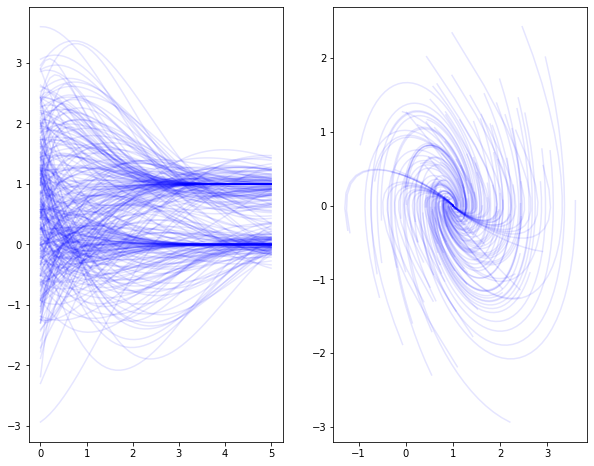

In [151]:
fig = plt.figure(figsize=(10, 8))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

for i in range(0, 30840, 200):
    ax0.plot(t_span, data[:,i,:], color='b', alpha=.1)

for i in range(0, 30840, 200):
    ax1.plot(data[:,i,0], data[:,i,1], color='b', alpha=.1)

## Corrupt the data

In [183]:
data_under = nn.Dropout(p=0.1)(data)
# add noise
idx_to_zero_0 = data_under[:, :, 0]==0
idx_to_zero_1 = data_under[:, :, 1]==0
data_under += 0.03*torch.rand_like(data_under)

# make sure entire obs is removed
data_under[idx_to_zero_0] = 0
data_under[idx_to_zero_1] = 0

IndexError: index 6000 is out of bounds for dimension 1 with size 6000

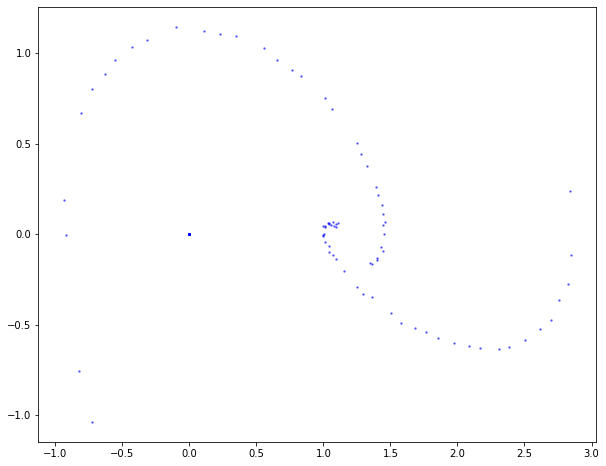

In [184]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(1,1,1)

#for i in range(0, 30840, 200):
#    ax0.scatter(t_span, data_under[:,i,:], color='b', alpha=.1)

for i in range(0, 30840, 3000):
    ax1.scatter(data_under[:,i,0], data_under[:,i,1], s=2, color='b', alpha=.5)

In [186]:
torch.save(data, 'data/true_data_06_1_14')

In [171]:
!cwd

/bin/sh: 1: cwd: not found
